# Методы сжатия и обработки видео

Кроме того, ещё одним параметром работы будет являться **скорость работы**.

In [1]:
# Импортируем нужные библиотеки
import cv2
import time
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
%matplotlib inline

In [2]:
#Библиотека для чтения видео
class VideoReader:
    def __init__(self, path):
        self.cap = cv2.VideoCapture(path)
        self.height = int(self.cap.get(4))
        self.width = int(self.cap.get(3))
    
    def __iter__(self):
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            if ret == False:
                break
            yield frame
    
    def height(self):
        return self.heigth
    
    def width(self):
        return self.width
    
    def __del__(self):
        self.cap.release()

def generate_pair_frames_gray(video):
    prev_frame = None
    for frame in video:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        if prev_frame is None:
            prev_frame = frame
        else:
            yield prev_frame, frame
            prev_frame = frame

In [3]:
def show_pair_frames(compensated_frame, frame, psnr_value):
    fig = plt.figure(figsize=(16,7))
    plt.suptitle('Значение PSNR: {:.4f}'.format(psnr_value), fontsize=24)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(compensated_frame, cmap='gray')
    ax.set_title("Скомпенсированный кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(frame, cmap='gray')
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
def visualize_motion_vectors(img, ofs, block_size=16):
    ver, hor = ofs[0], ofs[1]
    ver = cv2.resize(ver, (ver.shape[1] // block_size, ver.shape[0] // block_size))
    hor = cv2.resize(hor, (hor.shape[1] // block_size, hor.shape[0] // block_size))

    height, width = ver.shape

    xx, yy = np.meshgrid(np.arange(width), np.arange(height))

    xx = block_size * (xx + 0.5)
    yy = block_size * (yy + 0.5)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img, cmap='gray', alpha=0.5)
    plt.quiver(xx, yy, hor, -ver)
    plt.xticks([])
    plt.yticks([])

In [5]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Простая функция для тестирования ME.
def test_me(source_video, me, return_frames=False, result_path=None, return_ofs=False):
    ssim = []
    psnr = []
    speed = []
    compensated_frames = []
    source_frames = []
    ofs = []
    out_video = None
    if result_path is not None:
        out_video = cv2.VideoWriter(
            result_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            10,
            (source_video.width, source_video.height * 2)
        )
     
    pbar = tqdm(generate_pair_frames_gray(source_video))
    for frame, prev_frame in pbar:
        start = time.time()
        result = me.Estimate(frame, prev_frame) # Запускаем me
        end = time.time()
        speed.append((end - start) * 1000)
        compensated_frame = result.Remap(prev_frame) # Скомпенсированный кадр лежит тут. Полезно для дебага его отсюда доставать и рассматривать.
        
        ssim.append(structural_similarity(frame, compensated_frame, multichannel=False))
        psnr.append(peak_signal_noise_ratio(frame, compensated_frame))
        if return_frames:
            compensated_frames.append(compensated_frame)
            source_frames.append(frame)
        if return_ofs:
            ofs.append(result.ConvertToOF())
        
        
        pbar.set_description('PSNR: {:.2f}; Time(ms): {:.2f}; SSIM: {:.2f}.'.format(np.mean(psnr), np.mean(speed), np.mean(ssim)))
        
        if out_video is not None:
            out_video.write(cv2.cvtColor(np.vstack([frame, compensated_frame]), cv2.COLOR_GRAY2BGR))
    if out_video is not None:
        out_video.release()
        
    return {
        'ssim': ssim,
        'psnr': psnr,
        'speed': speed,
        'compensated_frames': compensated_frames,
        'source_frames': source_frames,
        'ofs': ofs
    }

## Ваше решение

- В качестве решения вы должны прикрепить класс ниже.
- Менять прототипы для init и Estimate **нельзя**.
- **Должен** быть возможен вызов вида `test_me(video, me)`.

In [6]:
# GRADED CELL: MotionEstimator

class MotionEstimator:
    def __init__(self, width, height, quality, halfpixel):
        import me_estimator
        
        self.width = width
        self.height = height
        self.quality = quality
        self.halfpixel = halfpixel

        # На данный момент в me_estimator реализован полный перебор - смотреть MotionEstimator::CEstimate
        self.me = me_estimator.MotionEstimator(self.width, self.height, self.quality, self.halfpixel)

    def Estimate(self, frame, prev_frame):
        return self.me.Estimate(frame, prev_frame)

**Если вы делали какие-то изменения, то не забудьте перезагрузить модуль. Для этого нажмите Kernel->Restart**

In [7]:
video = VideoReader('video/source.avi')
me = MotionEstimator(video.width, video.height, 100, False)
result = test_me(video, me, True, 'result.mp4', True) # В result.mp4 сохраняем скомпенсированное видео, также в result будут лежать кадры

0it [00:00, ?it/s]

Посмотрим на то, как компенсируется произвольный кадр:

In [1]:
frame_idx = 1
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

NameError: name 'show_pair_frames' is not defined

Посмотрим на найденные вектора движения

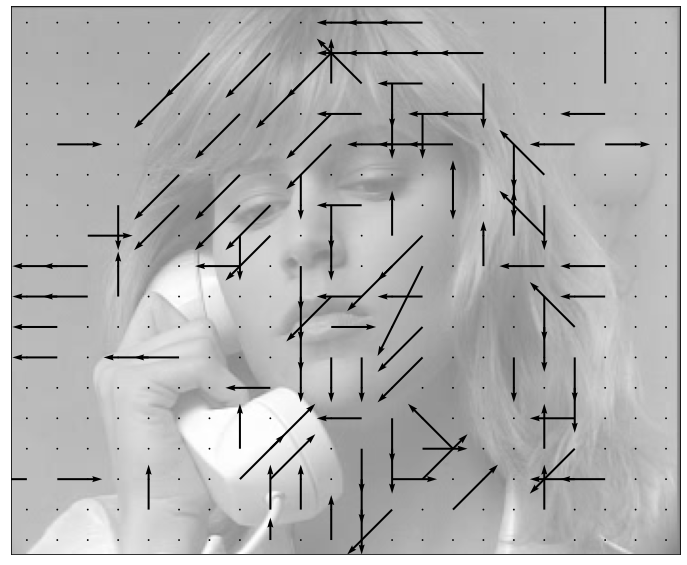

In [13]:
visualize_motion_vectors(
    result['source_frames'][frame_idx],
    result['ofs'][frame_idx]
)

Примером ниже можно посмотреть графики, как покадрово работает ваш алгоритм. 

<Figure size 864x432 with 0 Axes>

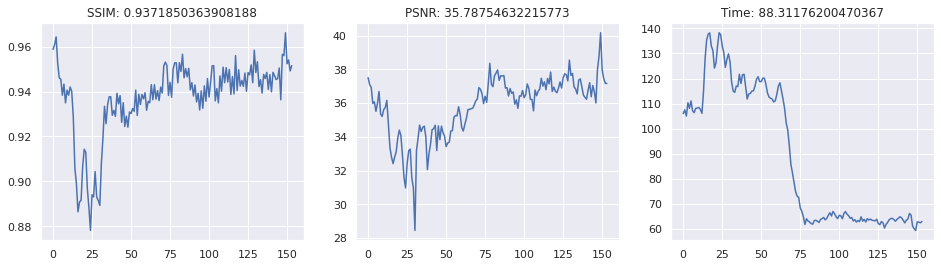

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

In [12]:
import pandas as pd

def test_all_me(video_paths=['source.avi'], qualities=[100, 80, 60, 40, 20], halfpixels=[False, True]):
    result = []
    for video_path in video_paths:
        for halfpixel in halfpixels:
            for quality in qualities:
                video = VideoReader(video_path)
                me = MotionEstimator(video.width, video.height, quality, halfpixel)
                metrics = test_me(video, me)
                result.append(
                    {
                        'video': video_path,
                        'halfpixel': halfpixel,
                        'quality': quality,
                        **{
                            key: np.mean(metrics[key])
                            for key in metrics
                        }
                    }
                )
    return pd.DataFrame(result)

In [13]:
result_all = test_all_me(
    video_paths=['video/source.avi'],
    qualities=[100],# 80, 60, 40, 20],
    halfpixels=[False]#, True]
)

0it [00:00, ?it/s]

/home/aa/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aa/.local/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
result_all

,video,halfpixel,quality,ssim,psnr,speed,compensated_frames,source_frames,ofs
0,video/source.avi,False,100,0.937185,35.787546,90.910401,NaN,NaN,NaN


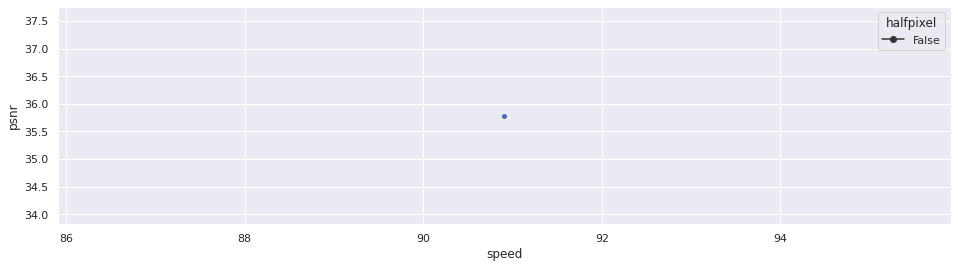

In [15]:
fig, axes = plt.subplots(1, len(result_all['video'].unique()), figsize=(16, 4))
if len(result_all['video'].unique()) == 1:
    axes = [axes]
for ax, video in zip(axes, result_all['video'].unique()):
    sns.lineplot(x='speed', y='psnr', style='halfpixel', markers=True, data=result_all[result_all.video == video], ax=ax)

# Дневник разработки

## 20 ноября

### Трехшаговый поиск

~Дорогой дневник~, реализовал трехшаговый поиск, результаты ниже. Судя по всему, алгоритм не очень хорош. 

При заметном ускорении psnr упал на 5 децибел по сравнению с полным перебором, что очень печально

In [9]:
video = VideoReader('video/source.avi')
me = MotionEstimator(video.width, video.height, 100, True)
result = test_me(video, me, True, 'result.mp4', True)

0it [00:00, ?it/s]

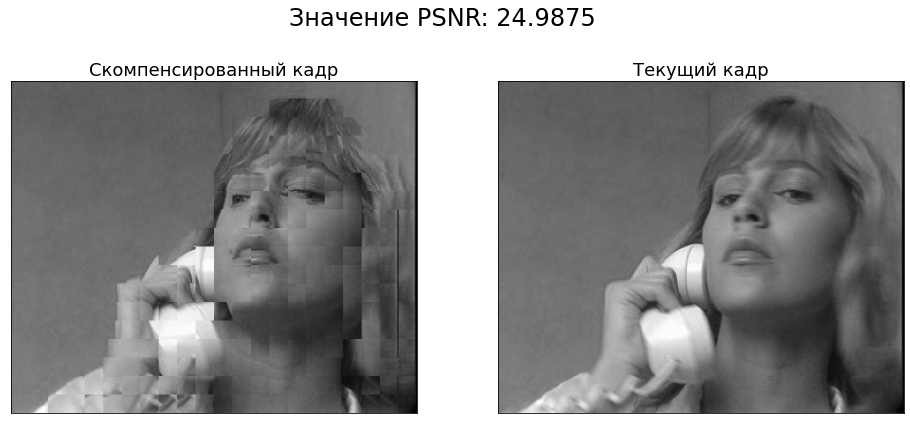

In [13]:
frame_idx = 24
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

<Figure size 864x432 with 0 Axes>

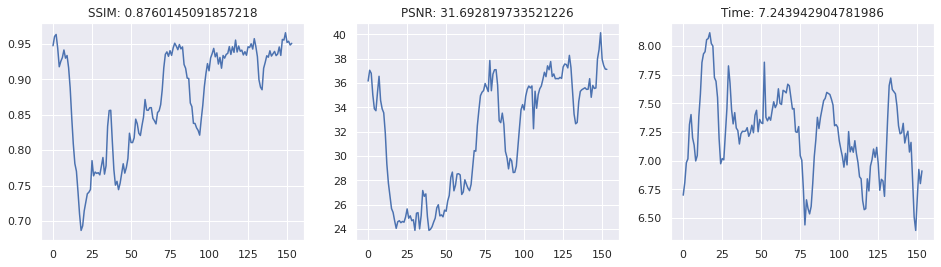

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

### Эксперименты с трехшаговым поиском (3SS)

#### 1. Хочу проверить гипотезу о том, что если ошибка между блоком в двух кадрах достаточно мала, то <br /> блок никуда не двигался, и можно производить только 1 вычисление вместо 9 

In [7]:
video = VideoReader('video/source.avi')
me = MotionEstimator(video.width, video.height, 100, False)
result = test_me(video, me, True, 'result.mp4', True)

0it [00:00, ?it/s]

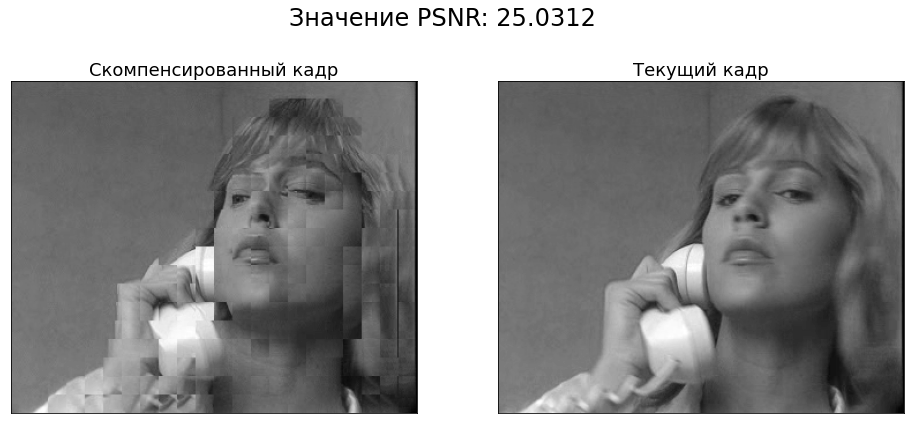

In [8]:
frame_idx = 24
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

<Figure size 864x432 with 0 Axes>

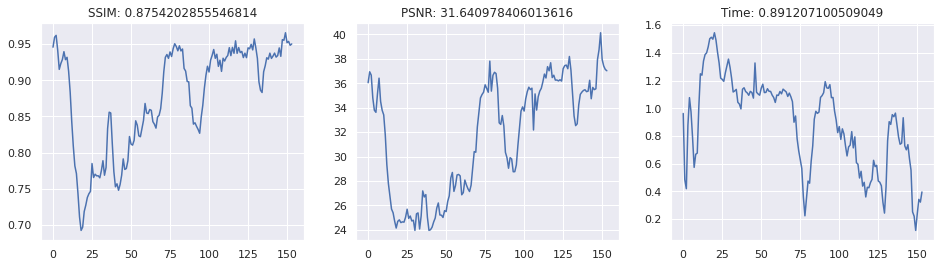

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

#### Вывод 1. Как видно, предположение оказалось верным. Если ошибка между блоками меньше 1000, мы оставляем этот же блок и идем дальше <br /> при таком подходе скорость вычисления увеличилась примерно на 1 мс, а PSNR упал меньше чем на 7 сотых

#### 2. Проверим, какие позиции чаще всего выбирает алгоритм на следующем шаге

С помощью printf и datamash получаем следующие данные <br />
24183| 30777| 23145 <br />
36936| 500493| 37212 <br />
22275| 30978| 22980 <br />
или в процентном соотношении ${sigma} = 728979 <br />
3%| 4%| 3% <br />
5%| 68%| 5% <br />
3%| 4%| 3% <br />
четко видно, что почти в 70% случаев алгоритм на следующем шаге остается на месте, то есть, большая часть вычислений проихводится впустую <br />
также стоит отметить, что горизонтальные и вертикальные точки встречаются чаще, чем угловые

### Выводы по трехшаговому поиску

Очевидно, что этот алгоритм не годится для MЕ. Скорость на хорошем уровне, однако PSNR крайне низкий.
Проанализировав результаты выше можно сделать вывод, что этот алгоритм слишком плохо подбирает МЕ-вектор для блоков
со слабым движением.
С другой стороны, стало понятно, что стоит оптимизировать стратегию поиска с учетом предыдущих векторов

## 21 ноября

### Предсказание по предыдущему вектору

#### Как я я писал выше, стало понятно, что нужно использовать информацию о движении соседних блоков. <br /> 
Изменения, которые я внес в алгоритм:
1. на каждом шаге(кроме случая x = 0) рассматриваем блок слева. Во-первых, вычисляем его r = норму + запоминаем координаты <br />
на первом шаге мы вычисляем 8 точек радиуса r, точку (0, 0) и координаты прошлого вектора. Идем в точку с меньшей ошибкой, <br />
после этого ищем наилучшую точку применяя 3ss радиуса 1, пока на очередном шаге алгоритм не переходит в новую точку

In [15]:
video = VideoReader('video/source.avi')
me = MotionEstimator(video.width, video.height, 100, True)
result = test_me(video, me, True, 'result.mp4', True) # В result.mp4 сохраняем скомпенсированное видео, также в result будут лежать кадры

0it [00:00, ?it/s]

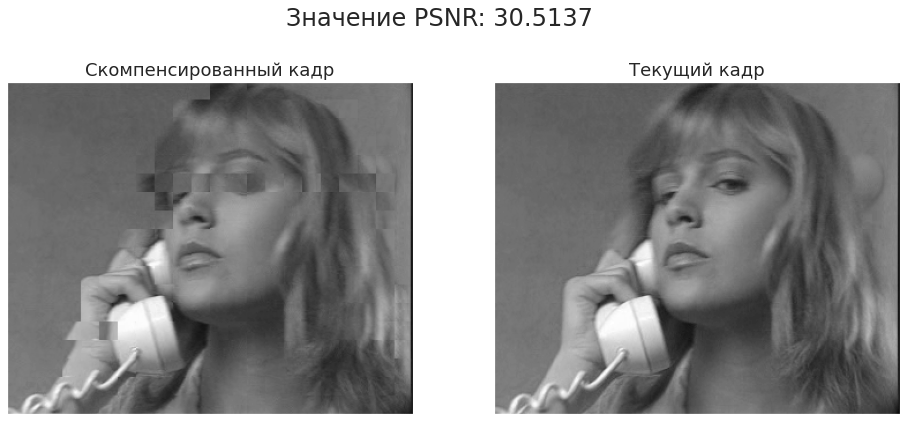

In [19]:
frame_idx = 20
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

<Figure size 864x432 with 0 Axes>

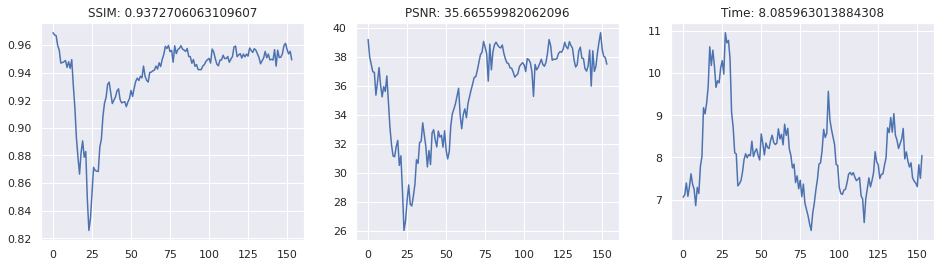

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

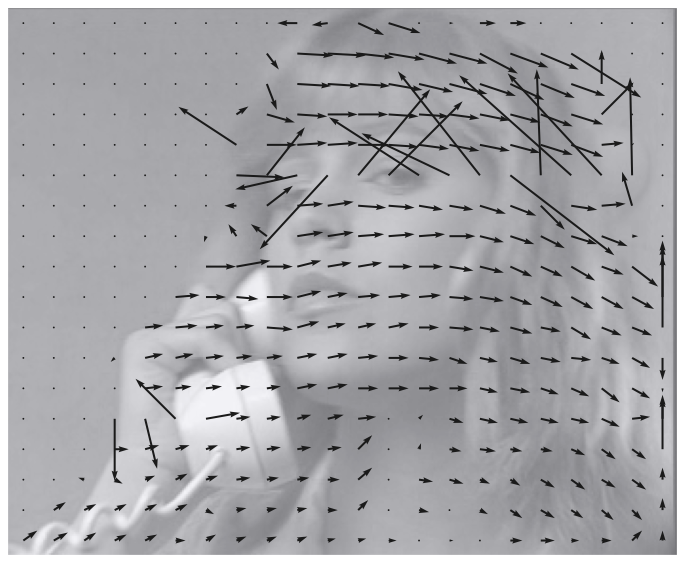

In [21]:
visualize_motion_vectors(
    result['source_frames'][frame_idx],
    result['ofs'][frame_idx]
)

### Выводы
Как видно по графикам выше, алгоритм существенном улучшает PSNR по сравнению с 3ss, однако до полнопереборного алгоритма <br />
результаты все равно не дотягивают. По скорости же можно отметить значительное улучшение. <br /> <br/>
Что плохо: как видно на картинке со стрелочками, предсказание только лишь по левому вектору крайне ненадежно. <br />
Например, строка блока с глазами: предсказание граничного (между Сюзи и фоном) вектора оказалось неудачным, <br />
и все последующие векторы в строке также были выбраны неудачно.

## 23-27 ноября

Было принято решение использовать контекст из 4 соседних блоков: слева, сверху-слева, сверху, сверху-справа.<br />
Это дало возможность посчитать некоторые характеристики движения: средний вектор, среднюю ошибку, скорость и так далее <br />
На основе этих данных можно более точно находить нужные блоки. Результаты приведены ниже

In [7]:
video = VideoReader('video/source.avi')
me = MotionEstimator(video.width, video.height, 100, False)
result = test_me(video, me, True, 'result.mp4', True) # В result.mp4 сохраняем скомпенсированное видео, также в result будут лежать кадры

0it [00:00, ?it/s]

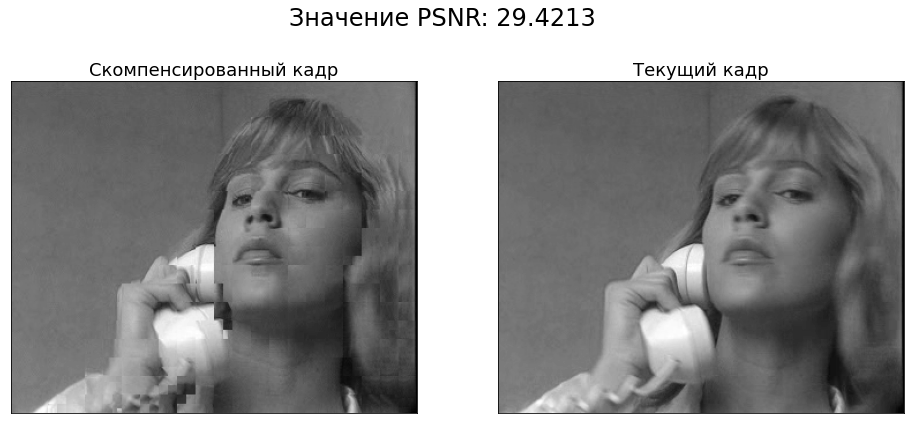

In [8]:
frame_idx = 24
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

<Figure size 864x432 with 0 Axes>

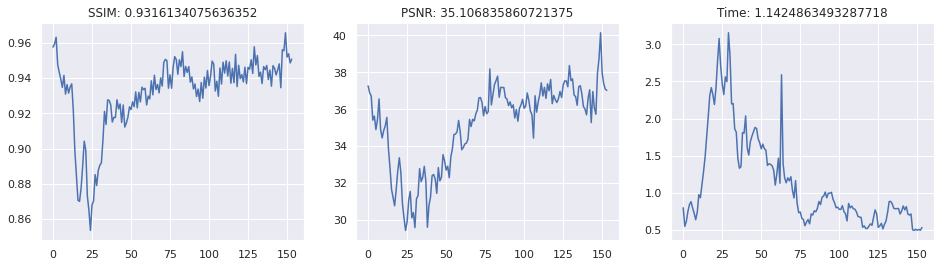

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

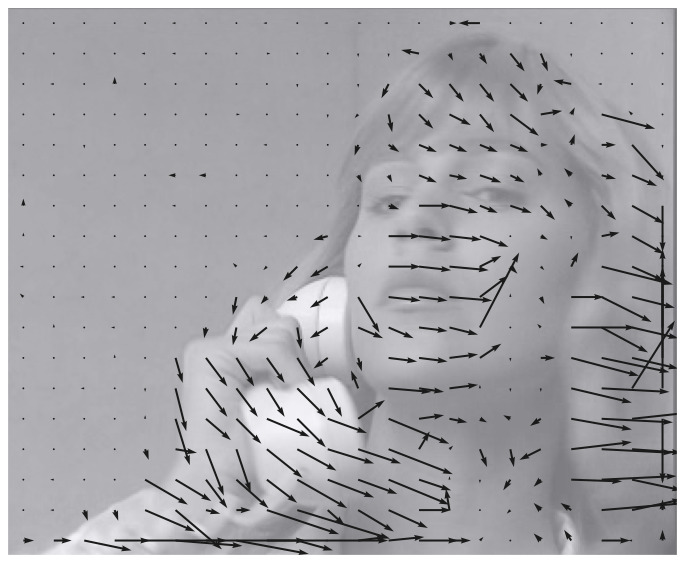

In [10]:
visualize_motion_vectors(
    result['source_frames'][frame_idx],
    result['ofs'][frame_idx]
)

## 28-29 ноября

В дополнение к 4 векторам в текущем кадре теперь добавляются два вектора из предыдущего. Это не так сильно <br />
увеличило время выполнения, но улучшило точность.

Также я продлил квадродерево до блоков 4х4, это позволило увеличить точность даже на высокой скорости

In [7]:
video = VideoReader('video/source.avi')
me = MotionEstimator(video.width, video.height, 100, False)
result = test_me(video, me, True, 'result.mp4', True) # В result.mp4 сохраняем скомпенсированное видео, также в result будут лежать кадры

0it [00:00, ?it/s]

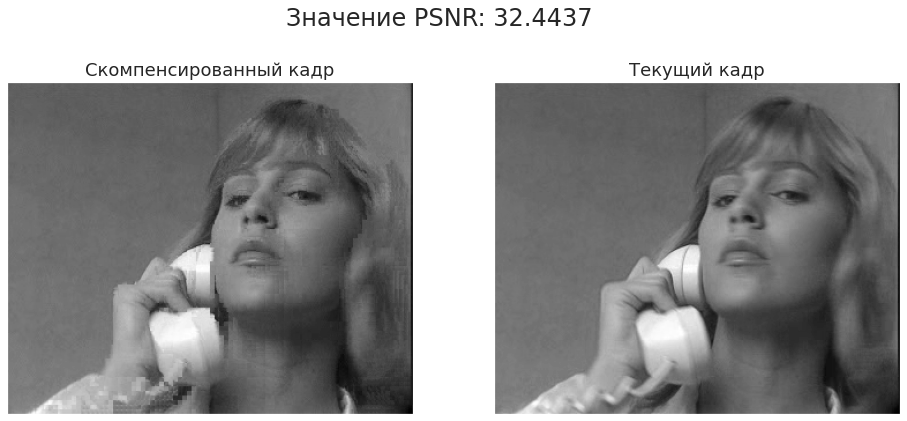

In [16]:
frame_idx = 24
show_pair_frames(
    result['compensated_frames'][frame_idx],
    result['source_frames'][frame_idx],
    result['psnr'][frame_idx]
)

<Figure size 864x432 with 0 Axes>

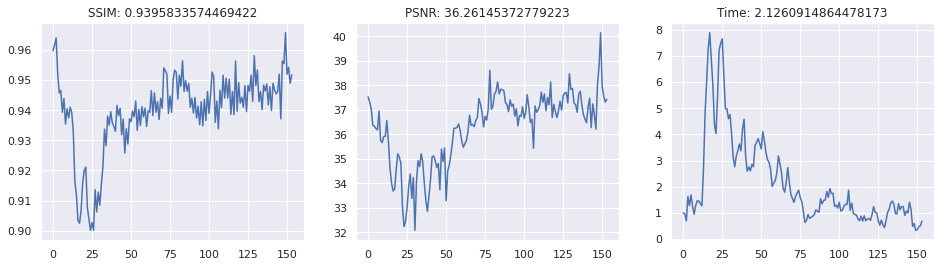

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("notebook")
plt.figure(figsize=(12, 6))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(result['ssim'])
ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
ax2.plot(result['psnr'])
ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
ax3.plot(result['speed'])
ax3.set_title('Time: {}'.format(np.mean(result['speed'])));

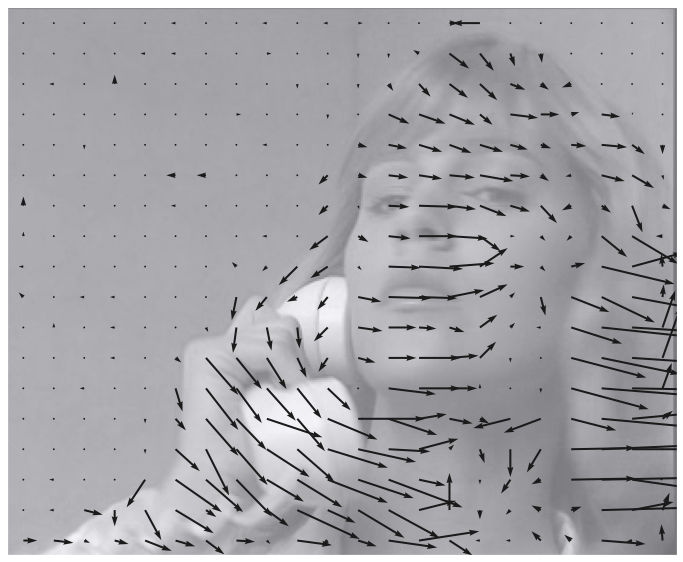

In [18]:
visualize_motion_vectors(
    result['source_frames'][frame_idx],
    result['ofs'][frame_idx]
)

Дополнительно я скачал несколько тестовых видеопоследовательностей, графики приведены ниже

In [19]:
import seaborn as sns
import pandas as pd

In [20]:
df = pd.read_csv("results.csv")

In [21]:
new = df[['video','halfpixel', 'speed', 'psnr']]

In [22]:
new['video'] = new['video'].str.slice(start=47)

<ipython-input-22-96e0dd26e61e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['video'] = new['video'].str.slice(start=47)


In [23]:
new["video"] = new["video"] + " " + new['halfpixel'].astype(str)

<ipython-input-23-cbb85e805dd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new["video"] = new["video"] + " " + new['halfpixel'].astype(str)


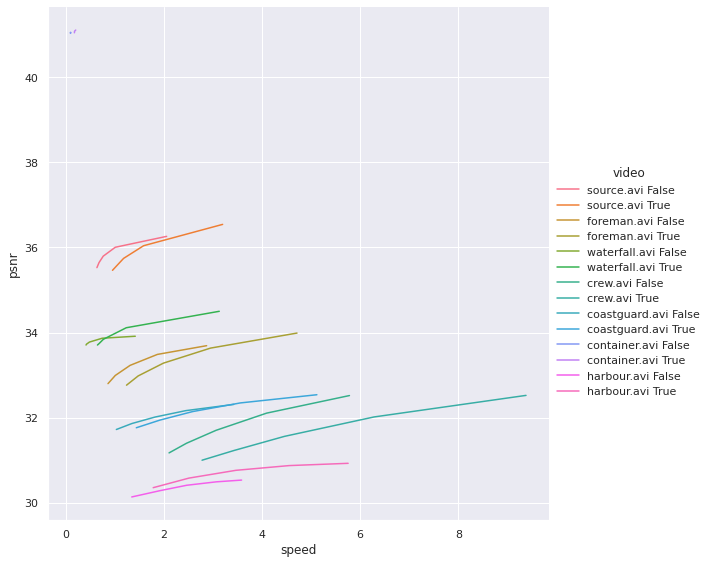

In [24]:
sea =sns.FacetGrid(data=new, hue='video', height=8)

# map the above form facetgrid with some attributes   
sea.map(sns.lineplot, "speed", "psnr", alpha = .99)
  
# adding legend
sea.add_legend()

## 30 ноября я крутил параметры